# READ ME

This is a training pipeline as of 19.06.2025 where we start to include more complex predictive models in our project. First, we introduce the Temporal Fusion Transformer (TFT) and Temporal ConvNet (TCN) models.

In [138]:
import torch, sympy, inspect, importlib
print("torch :", torch.__version__)
print("sympy :", sympy.__version__)
print("sympy has printing ?", hasattr(sympy, "printing"))

torch : 2.5.1
sympy : 1.13.1
sympy has printing ? True


In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Union, Any
import warnings
import random
from Base_models import FeedForwardPredictor, AutoEncoder, ElasticNetLoss
from TM_models import TemporalConvNet
import math

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # might slow down but ensures reproducibility
    torch.backends.cudnn.benchmark = False
    
set_seed()

def calculate_sharpe_ratio(strategy_returns: np.ndarray, rf_rate: float) -> float:
    """Calculate annualized Sharpe ratio using strategy returns and actual risk-free rate"""
    if len(strategy_returns) == 0 or np.std(strategy_returns) == 0:
        return 0.0
    # rf_rate is already annual, convert to daily
    daily_rf = rf_rate / 252  # Assuming daily data
    excess_returns = strategy_returns - daily_rf
    return np.sqrt(252) * np.mean(excess_returns) / np.std(strategy_returns)

def calculate_sortino_ratio(strategy_returns: np.ndarray, rf_rate: float) -> float:
    """Calculate annualized Sortino ratio using strategy returns and actual risk-free rate"""
    if len(strategy_returns) == 0:
        return 0.0
    # rf_rate is already annual, convert to daily
    daily_rf = rf_rate / 252  # Assuming daily data
    excess_returns = strategy_returns - daily_rf
    downside_returns = excess_returns[excess_returns < 0]
    if len(downside_returns) == 0:
        return np.inf
    return np.sqrt(252) * np.mean(excess_returns) / np.std(downside_returns)

def hit_rate(pred: np.ndarray, targ: np.ndarray) -> float:
    """Percentage of months the sign is predicted correctly."""
    return np.mean(np.sign(pred) == np.sign(targ))

def train_autoencoder(X_train: np.ndarray, encoding_dim: int, epochs: int = 100, 
                     lr: float = 0.001, device: str = 'cpu') -> AutoEncoder:
    """Train autoencoder on training data only"""
    input_dim = X_train.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    
    X_tensor = torch.FloatTensor(X_train).to(device)
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    autoencoder.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            x_batch = batch[0]
            optimizer.zero_grad()
            reconstructed = autoencoder(x_batch)
            loss = criterion(reconstructed, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
    autoencoder.eval()
    return autoencoder

def train_model_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module,
                     optimizer: optim.Optimizer, scheduler=None, model_type: str = 'feedforward', device: str = 'cpu') -> float:
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        
        if model_type.lower() == 'transformer':
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        if scheduler and isinstance(scheduler, optim.lr_scheduler.OneCycleLR):
            scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# def evaluate_model(model: nn.Module, dataloader: DataLoader, criterion: nn.Module,
#                   device: str) -> Tuple[float, np.ndarray, np.ndarray]:
#     """Evaluate model and return loss, predictions, and targets"""
#     model.eval()
#     total_loss = 0
#     all_predictions = []
#     all_targets = []
    
#     with torch.no_grad():
#         for X_batch, y_batch in dataloader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             predictions = model(X_batch).squeeze()
#             loss = criterion(predictions, y_batch)
#             total_loss += loss.item()
#             all_predictions.extend(predictions.cpu().numpy())
#             all_targets.extend(y_batch.cpu().numpy())
    
#     return total_loss / len(dataloader), np.array(all_predictions), np.array(all_targets)

def evaluate_model(model: nn.Module,
                   dataloader: DataLoader,
                   criterion: nn.Module,
                   device: str) -> Tuple[float, np.ndarray, np.ndarray]:

    model.eval()
    total_loss = 0.0
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # ── 1. keep the batch axis ───────────────────────────────
            predictions = model(X_batch).squeeze(-1)      # shape: (batch_size,)
            y_batch     = y_batch.squeeze(-1)             # same for targets

            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # ── 2. flatten before extending the lists ───────────────
            all_predictions.extend(predictions.cpu().numpy().ravel())
            all_targets.extend(y_batch.cpu().numpy().ravel())

    avg_loss = total_loss / len(dataloader)
    return avg_loss, np.array(all_predictions), np.array(all_targets)

def get_optimizer_for_model(model: nn.Module, model_type: str, lr: float = 0.001):
    """Get appropriate optimizer based on model type."""
    if model_type.lower() == 'transformer':
        # AdamW often works better for transformers
        return optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, betas=(0.9, 0.999))
    else:
        # Standard Adam for other models
        return optim.Adam(model.parameters(), lr=lr)

def get_learning_rate_scheduler(optimizer, model_type: str, num_training_steps: int = None):
    """Get appropriate learning rate scheduler based on model type."""
    if model_type.lower() == 'transformer' and num_training_steps:
        # Warmup scheduler for transformers
        return optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=optimizer.param_groups[0]['lr'] * 10,
            total_steps=num_training_steps,
            pct_start=0.1  # 10% warmup
        )
    else:
        # Simple step scheduler for other models
        return optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

def prepare_data_for_model(
    X: np.ndarray,
    y: np.ndarray,
    model_type: str,
    seq_length: int = 12,
    ar_lags: int = 5
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Convert raw arrays to tensors, respecting model expectations."""
    seq_models = ['lstm', 'transformer', 'tcn', 'temporalconvnet',
              'cnn', 'conv1d', 'simpleconvolutional']
    if model_type.lower() in seq_models:
        X_seq, y_seq = [], []
        for i in range(max(seq_length, ar_lags), len(X)):
            feature_seq = X[i - seq_length:i]
            ar_returns  = y[i - ar_lags:i].reshape(-1, 1)

            ar_pad = np.zeros((seq_length, ar_lags))
            ar_pad[-1, :] = ar_returns.ravel()

            X_seq.append(np.concatenate([feature_seq, ar_pad], axis=1))
            y_seq.append(y[i])

        return torch.FloatTensor(np.asarray(X_seq)), torch.FloatTensor(np.asarray(y_seq))

    # ── feed‑forward path ───────────────────────────────────────────
    X_ff, y_ff = [], []
    for i in range(ar_lags, len(X)):
        current_features = X[i]
        ar_returns       = y[i - ar_lags:i]
        X_ff.append(np.concatenate([current_features, ar_returns]))
        y_ff.append(y[i])

    return torch.FloatTensor(np.asarray(X_ff)), torch.FloatTensor(np.asarray(y_ff))


def sp500_training_pipeline(
    X: np.ndarray,
    y: np.ndarray,
    dates: pd.DatetimeIndex,
    tbill3m: np.ndarray,
    model_class: type,
    model_kwargs: Dict[str, Any],
    model_type: str = 'feedforward',
    window_strategy: str = 'rolling',
    train_window_years: int = 3,
    test_window_years: int = 1,
    use_autoencoder: bool = True,
    encoding_dim: int = 10,
    walk_forward_cv: bool = False,
    cv_months: int = 2,
    seq_length: int = 12,
    ar_lags: int = 5,
    epochs: int = 100,
    lr: float = 0.001,
    batch_size: int = 32,
    alpha: float = 0.1,
    l1_ratio: float = 0.5,
    device: str = 'cpu',
    random_seed: int = 42,
    plot_results: bool = True
) -> Dict[str, Any]:
    """Rolling / expanding‑window S&P‑500 forecast pipeline plus TCN support."""

    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    if not isinstance(dates, pd.DatetimeIndex):
        dates = pd.DatetimeIndex(dates)

    # === master container =========================================
    results: Dict[str, Any] = {
        'fold_results': [], 'scalers': [], 'autoencoders': [], 'models': [],
        'all_train_predictions': [], 'all_train_targets': [],
        'all_test_predictions':  [], 'all_test_targets':  [],
        'all_train_dates': [],     'all_test_dates':     [],
        'metrics': {
            'train_mse': [], 'test_mse': [],
            'train_sharpe': [], 'test_sharpe': [],
            'train_mae': [], 'test_mae': [],
            'train_r2':  [], 'test_r2':  [],
            'train_sortino': [], 'test_sortino': [],
            'train_hit': [], 'test_hit': []
        }
    }

    # --- per‑fold arrays for optional plotting --------------------
    fold_predictions, fold_targets, fold_dates = [], [], []

    # === build fold timeline ======================================
    start_date, end_date = dates[0], dates[-1]
    fold_start_dates, cur = [], start_date + pd.DateOffset(years=train_window_years)
    while cur + pd.DateOffset(years=test_window_years) <= end_date:
        fold_start_dates.append(cur)
        cur += pd.DateOffset(years=test_window_years)

    print(f"Starting {window_strategy} window training with {len(fold_start_dates)} folds")
    seq_models = ['lstm', 'transformer', 'tcn', 'temporalconvnet',
              'cnn', 'conv1d', 'simpleconvolutional']

    # === walk through every fold ==================================
    for fold_idx, test_start_date in enumerate(fold_start_dates, 1):
        print(f"\n— Fold {fold_idx}/{len(fold_start_dates)} —")
        test_end_date  = test_start_date + pd.DateOffset(years=test_window_years)
        train_start_date = (test_start_date - pd.DateOffset(years=train_window_years)
                            if window_strategy == 'rolling' else start_date)

        train_mask = (dates >= train_start_date) & (dates < test_start_date)
        test_mask  = (dates >= test_start_date) & (dates < test_end_date)
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            print("Skipping fold – insufficient data")
            continue

        # ----------- slice data ----------------------------------
        X_train, y_train = X[train_mask], y[train_mask]
        X_test,  y_test  = X[test_mask],  y[test_mask]
        train_dates, test_dates = dates[train_mask], dates[test_mask]

        # ----------- scaling -------------------------------------
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # ----------- optional autoencoder ------------------------
        autoencoder = None
        if use_autoencoder:
            autoencoder = train_autoencoder(X_train_scaled, encoding_dim, epochs=50, lr=lr, device=device)
            with torch.no_grad():
                X_train_scaled = autoencoder.encode(torch.FloatTensor(X_train_scaled).to(device)).cpu().numpy()
                X_test_scaled  = autoencoder.encode(torch.FloatTensor(X_test_scaled) .to(device)).cpu().numpy()

        # ----------- AR‑lag augmentation -------------------------
        X_train_tensor, y_train_tensor = prepare_data_for_model(X_train_scaled, y_train,
                                                                model_type, seq_length, ar_lags)
        X_test_tensor,  y_test_tensor  = prepare_data_for_model(X_test_scaled,  y_test,
                                                                model_type, seq_length, ar_lags)
        offset = max(seq_length, ar_lags) if model_type.lower() in seq_models else ar_lags
        train_dates_adj, test_dates_adj = train_dates[offset:], test_dates[offset:]

        # ----------- model / optimiser ---------------------------
        input_dim = X_train_tensor.shape[-1]
        model     = model_class(input_dim=input_dim, **model_kwargs).to(device)
        criterion = ElasticNetLoss(model=model, alpha=alpha, l1_ratio=l1_ratio)
        optimizer = get_optimizer_for_model(model, model_type, lr)
        scheduler = get_learning_rate_scheduler(optimizer, model_type)

        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        test_loader  = DataLoader(TensorDataset(X_test_tensor,  y_test_tensor),  batch_size=batch_size, shuffle=False)

        # ----------- training loop -------------------------------
        print("Training final model…")
        final_epochs = epochs // 2 if walk_forward_cv else epochs
        for ep in range(final_epochs):
            loss = train_model_epoch(model, train_loader, criterion, optimizer, scheduler=scheduler,
                                      model_type=model_type, device=device)
            if (ep + 1) % 20 == 0:
                print(f"  epoch {ep+1}/{final_epochs}  loss={loss:.6f}")

        # ----------- evaluation ----------------------------------
        _, train_predictions, train_targets = evaluate_model(model, train_loader, criterion, device)
        _, test_predictions,  test_targets  = evaluate_model(model, test_loader,  criterion, device)

        # ----------- metric calc ---------------------------------
        train_mse = mean_squared_error(train_targets, train_predictions)
        test_mse  = mean_squared_error(test_targets,  test_predictions)
        train_mae = mean_absolute_error(train_targets, train_predictions)
        test_mae  = mean_absolute_error(test_targets,  test_predictions)
        train_r2  = r2_score(train_targets, train_predictions)
        test_r2   = r2_score(test_targets,  test_predictions)

        train_positions = np.sign(train_predictions)
        test_positions  = np.sign(test_predictions)
        train_strategy_returns = train_positions * train_targets
        test_strategy_returns  = test_positions  * test_targets

        train_rf = np.mean(tbill3m[train_mask])
        test_rf  = np.mean(tbill3m[test_mask])

        train_sharpe  = calculate_sharpe_ratio(train_strategy_returns, train_rf)
        test_sharpe   = calculate_sharpe_ratio(test_strategy_returns,  test_rf)
        train_sortino = calculate_sortino_ratio(train_strategy_returns, train_rf)
        test_sortino  = calculate_sortino_ratio(test_strategy_returns,  test_rf)

        train_hit = hit_rate(train_predictions, train_targets)
        test_hit  = hit_rate(test_predictions,  test_targets)

        print(f"Train MSE {train_mse:.6f} | MAE {train_mae:.6f} | R² {train_r2:.4f} | Sharpe {train_sharpe:.3f} | Sortino {train_sortino:.3f} | Hit {train_hit:.2%}")
        print(f"Test  MSE {test_mse:.6f} | MAE {test_mae:.6f} | R² {test_r2:.4f} | Sharpe {test_sharpe:.3f} | Sortino {test_sortino:.3f} | Hit {test_hit:.2%}")

        # Store results - everything below remains the same
        fold_result = {
            'fold': fold_idx,
            'train_period': (train_dates[0], train_dates[-1]),
            'test_period': (test_dates[0], test_dates[-1]),
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_sharpe': train_sharpe,
            'test_sharpe': test_sharpe,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_sortino': train_sortino,
            'test_sortino': test_sortino,
            'train_hit': train_hit,
            'test_hit': test_hit,
            'train_predictions': train_predictions,
            'test_predictions': test_predictions,
            'train_targets': train_targets,
            'test_targets': test_targets,
            'train_dates': train_dates_adj,
            'test_dates': test_dates_adj
        }
        
        results['fold_results'].append(fold_result)
        results['scalers'].append(scaler)
        results['autoencoders'].append(autoencoder)
        results['models'].append(model.state_dict())
        
        # Accumulate for overall plotting
        results['all_train_predictions'].extend(train_predictions)
        results['all_train_targets'].extend(train_targets)
        results['all_test_predictions'].extend(test_predictions)
        results['all_test_targets'].extend(test_targets)
        results['all_train_dates'].extend(train_dates_adj)
        results['all_test_dates'].extend(test_dates_adj)
        
        results['metrics']['train_mse'].append(train_mse)
        results['metrics']['test_mse'].append(test_mse)
        results['metrics']['train_sharpe'].append(train_sharpe)
        results['metrics']['test_sharpe'].append(test_sharpe)
        results['metrics']['train_mae'].append(train_mae)
        results['metrics']['test_mae'].append(test_mae)
        results['metrics']['train_r2'].append(train_r2)
        results['metrics']['test_r2'].append(test_r2)
        results['metrics']['train_sortino'].append(train_sortino)
        results['metrics']['test_sortino'].append(test_sortino)
        results['metrics']['train_hit'].append(train_hit)
        results['metrics']['test_hit'].append(test_hit)
        
        # Store for individual fold plotting
        fold_predictions.append((train_predictions, test_predictions))
        fold_targets.append((train_targets, test_targets))
        fold_dates.append((train_dates_adj, test_dates_adj))
    
    # Calculate overall metrics
    if results['metrics']['train_mse']:
        results['overall_metrics'] = {
            'avg_train_mse': np.mean(results['metrics']['train_mse']),
            'avg_test_mse': np.mean(results['metrics']['test_mse']),
            'avg_train_sharpe': np.mean(results['metrics']['train_sharpe']),
            'avg_test_sharpe': np.mean(results['metrics']['test_sharpe']),
            'std_train_mse': np.std(results['metrics']['train_mse']),
            'std_test_mse': np.std(results['metrics']['test_mse']),
            'std_train_sharpe': np.std(results['metrics']['train_sharpe']),
            'std_test_sharpe': np.std(results['metrics']['test_sharpe']),
            'avg_train_mae': np.mean(results['metrics']['train_mae']),
            'avg_test_mae': np.mean(results['metrics']['test_mae']),
            'std_train_mae': np.std(results['metrics']['train_mae']),
            'std_test_mae': np.std(results['metrics']['test_mae']),
            'avg_train_r2': np.mean(results['metrics']['train_r2']),
            'avg_test_r2': np.mean(results['metrics']['test_r2']),
            'std_train_r2': np.std(results['metrics']['train_r2']),
            'std_test_r2': np.std(results['metrics']['test_r2']),
            'avg_train_sortino': np.mean(results['metrics']['train_sortino']),
            'avg_test_sortino': np.mean(results['metrics']['test_sortino']),
            'std_train_sortino': np.std(results['metrics']['train_sortino']),
            'std_test_sortino': np.std(results['metrics']['test_sortino']),
            'avg_train_hit': np.mean(results['metrics']['train_hit']),
            'avg_test_hit': np.mean(results['metrics']['test_hit']),
            'std_train_hit': np.std(results['metrics']['train_hit']),
            'std_test_hit': np.std(results['metrics']['test_hit'])
        }
        
        print("\n=== OVERALL RESULTS ===")
        print(f"Average Train MSE: {results['overall_metrics']['avg_train_mse']:.6f} ± {results['overall_metrics']['std_train_mse']:.6f}")
        print(f"Average Test MSE: {results['overall_metrics']['avg_test_mse']:.6f} ± {results['overall_metrics']['std_test_mse']:.6f}")
        print(f"Average Train Sharpe: {results['overall_metrics']['avg_train_sharpe']:.4f} ± {results['overall_metrics']['std_train_sharpe']:.4f}")
        print(f"Average Test Sharpe: {results['overall_metrics']['avg_test_sharpe']:.4f} ± {results['overall_metrics']['std_test_sharpe']:.4f}")
        print(f"Average Train MAE: {results['overall_metrics']['avg_train_mae']:.6f} ± {results['overall_metrics']['std_train_mae']:.6f}")
        print(f"Average Test MAE: {results['overall_metrics']['avg_test_mae']:.6f} ± {results['overall_metrics']['std_test_mae']:.6f}")
        print(f"Average Train R²: {results['overall_metrics']['avg_train_r2']:.4f} ± {results['overall_metrics']['std_train_r2']:.4f}")
        print(f"Average Test R²: {results['overall_metrics']['avg_test_r2']:.4f} ± {results['overall_metrics']['std_test_r2']:.4f}")
        print(f"Average Train Sortino: {results['overall_metrics']['avg_train_sortino']:.4f} ± {results['overall_metrics']['std_train_sortino']:.4f}") 
        print(f"Average Test Sortino: {results['overall_metrics']['avg_test_sortino']:.4f} ± {results['overall_metrics']['std_test_sortino']:.4f}")
        print(f"Average Train Hit Rate: {results['overall_metrics']['avg_train_hit']:.2%} ± {results['overall_metrics']['std_train_hit']:.2%}")
        print(f"Average Test Hit Rate: {results['overall_metrics']['avg_test_hit']:.2%} ± {results['overall_metrics']['std_test_hit']:.2%}")

    
    # Plotting
    if plot_results and fold_predictions:
        n_plots = len(fold_predictions)
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots))
        if n_plots == 1:
            axes = [axes]
        
        for i, (fold_pred, fold_targ, fold_date) in enumerate(zip(fold_predictions, fold_targets, fold_dates)):
            train_pred, test_pred = fold_pred
            train_targ, test_targ = fold_targ
            train_date, test_date = fold_date
            
            ax = axes[i]

            # Plot actual returns (always black)
            ax.plot(train_date, train_targ, 'k-', label='Actual Returns', linewidth=1)
            ax.plot(test_date, test_targ, 'k-', linewidth=1)
            
            # Plot predictions (blue for train, red for test)
            ax.plot(train_date, train_pred, 'b-', label='Train Predictions', alpha=0.7)
            ax.plot(test_date, test_pred, 'r-', label='Test Predictions', alpha=0.7)
            
            # Add vertical line to separate train/test
            if len(test_date) > 0:
                ax.axvline(x=test_date[0], color='gray', linestyle='--', alpha=0.5)
            
            ax.set_title(f'Fold {i+1}: Predictions vs Actual Returns')
            ax.set_ylabel('Returns')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Overall performance plot
        if len(results['all_train_dates']) > 0:
            plt.figure(figsize=(15, 6))
            
            # Combine and sort all data by date
            all_data = []
            for train_pred, train_targ, train_date in zip(
                [results['fold_results'][i]['train_predictions'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['train_targets'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['train_dates'] for i in range(len(results['fold_results']))]
            ):
                for pred, targ, date in zip(train_pred, train_targ, train_date):
                    all_data.append((date, targ, pred, 'train'))
            
            for test_pred, test_targ, test_date in zip(
                [results['fold_results'][i]['test_predictions'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['test_targets'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['test_dates'] for i in range(len(results['fold_results']))]
            ):
                for pred, targ, date in zip(test_pred, test_targ, test_date):
                    all_data.append((date, targ, pred, 'test'))
            
            # Sort by date
            all_data.sort(key=lambda x: x[0])
            
            # Separate data
            dates_all = [x[0] for x in all_data]
            targets_all = [x[1] for x in all_data]
            predictions_all = [x[2] for x in all_data]
            types_all = [x[3] for x in all_data]
            
            # Plot
            plt.plot(dates_all, targets_all, 'k-', label='Actual Returns', linewidth=1)
            
            # Plot predictions with different colors
            train_mask = np.array(types_all) == 'train'
            test_mask = np.array(types_all) == 'test'
            
            if np.any(train_mask):
                plt.plot(np.array(dates_all)[train_mask], np.array(predictions_all)[train_mask], 
                        'b.', label='Train Predictions', alpha=0.7, markersize=3)
            if np.any(test_mask):
                plt.plot(np.array(dates_all)[test_mask], np.array(predictions_all)[test_mask], 
                        'r.', label='Test Predictions', alpha=0.7, markersize=3)
            
            plt.title('Overall Model Performance: Predictions vs Actual Returns')
            plt.ylabel('Returns')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    return results

In [140]:
df= pd.read_csv("data_non_std.csv",parse_dates=["Unnamed: 0"]).rename(columns={'Unnamed: 0': 'Date'}) 
features = df.drop(columns=["returns", "Date"])
target = df["returns"].values.astype(np.float32)
dates = pd.to_datetime(df["Date"]).astype('datetime64[ns]').tolist()


Starting rolling window training with 13 folds

— Fold 1/13 —
Training final model…
  epoch 20/80  loss=0.000164
  epoch 40/80  loss=0.000152
  epoch 60/80  loss=0.000134
  epoch 80/80  loss=0.000124
Train MSE 0.000111 | MAE 0.008011 | R² 0.3259 | Sharpe 6.354 | Sortino 11.491 | Hit 69.03%
Test  MSE 0.000088 | MAE 0.007290 | R² -0.2972 | Sharpe -0.023 | Sortino -0.036 | Hit 51.10%

— Fold 2/13 —
Training final model…
  epoch 20/80  loss=0.000225
  epoch 40/80  loss=0.000177
  epoch 60/80  loss=0.000134
  epoch 80/80  loss=0.000117
Train MSE 0.000101 | MAE 0.007814 | R² 0.2548 | Sharpe 4.335 | Sortino 9.628 | Hit 58.20%
Test  MSE 0.000110 | MAE 0.008641 | R² -1.0517 | Sharpe -2.976 | Sortino -4.726 | Hit 38.77%

— Fold 3/13 —
Training final model…
  epoch 20/80  loss=0.000120
  epoch 40/80  loss=0.000104
  epoch 60/80  loss=0.000089
  epoch 80/80  loss=0.000071
Train MSE 0.000066 | MAE 0.005999 | R² 0.4051 | Sharpe 7.047 | Sortino 15.437 | Hit 69.73%
Test  MSE 0.000064 | MAE 0.006372 | 

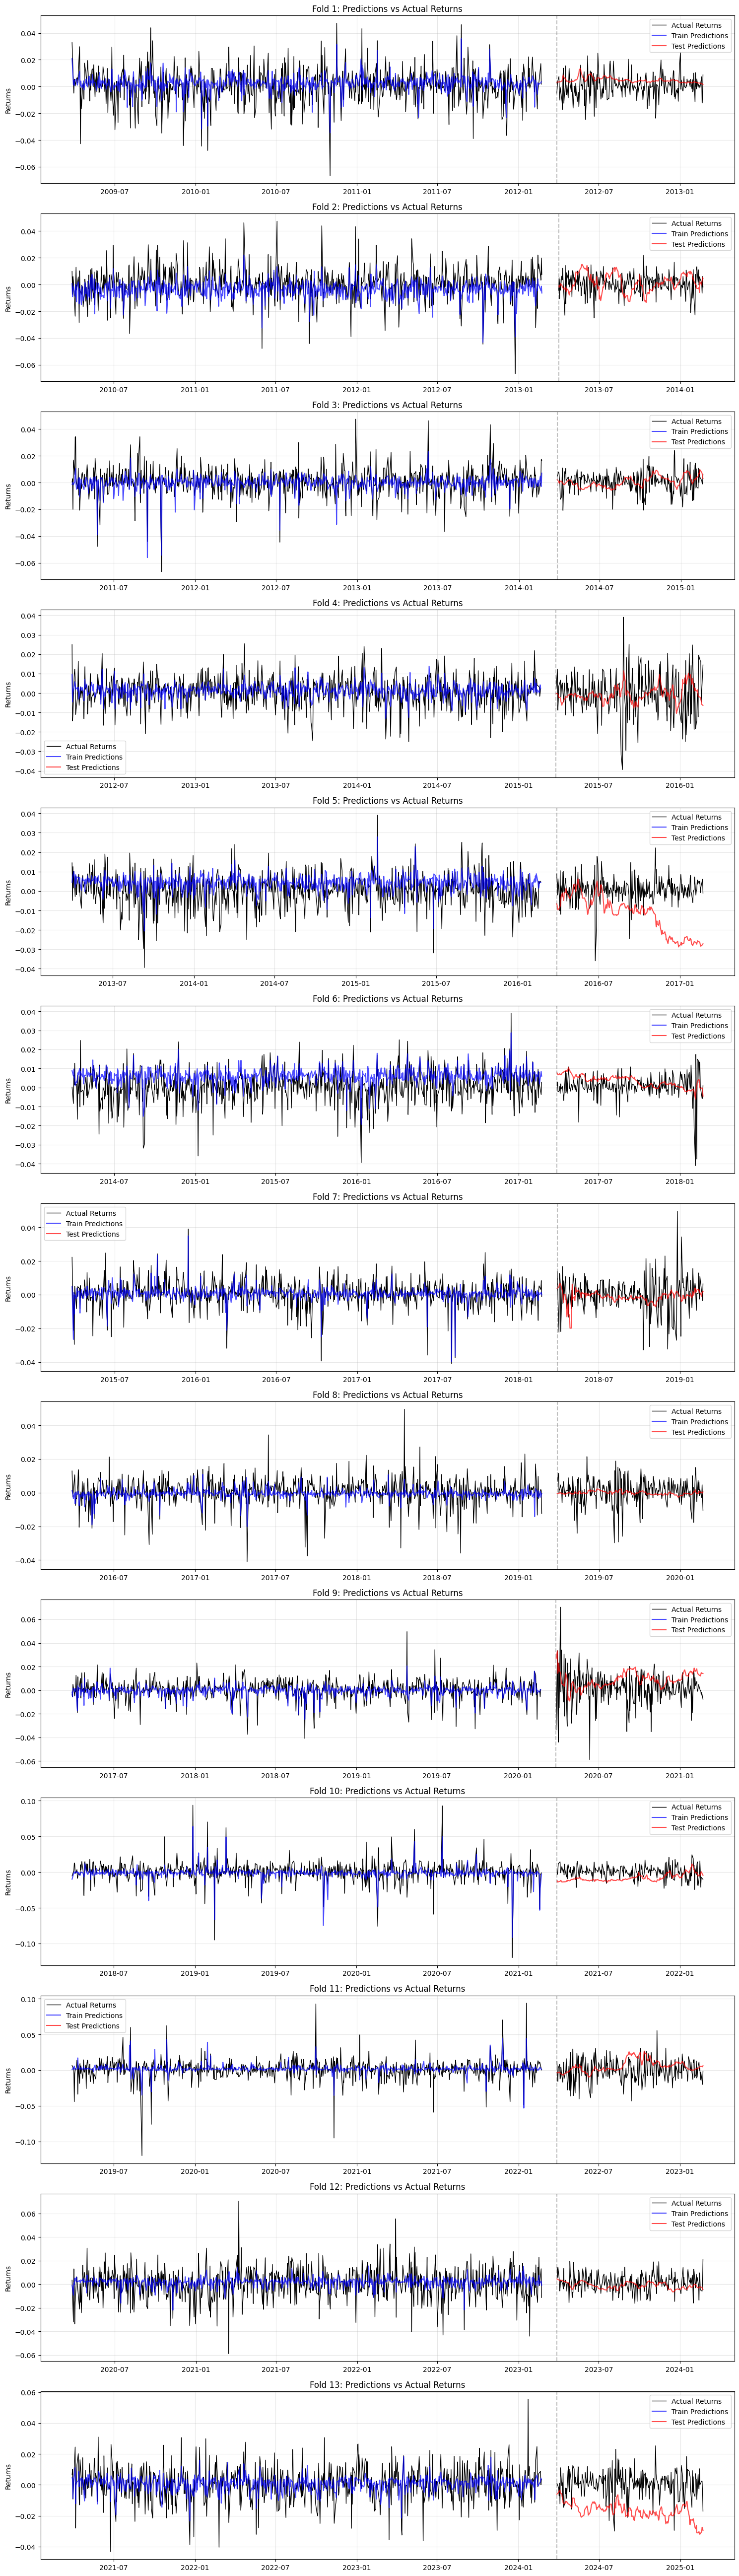

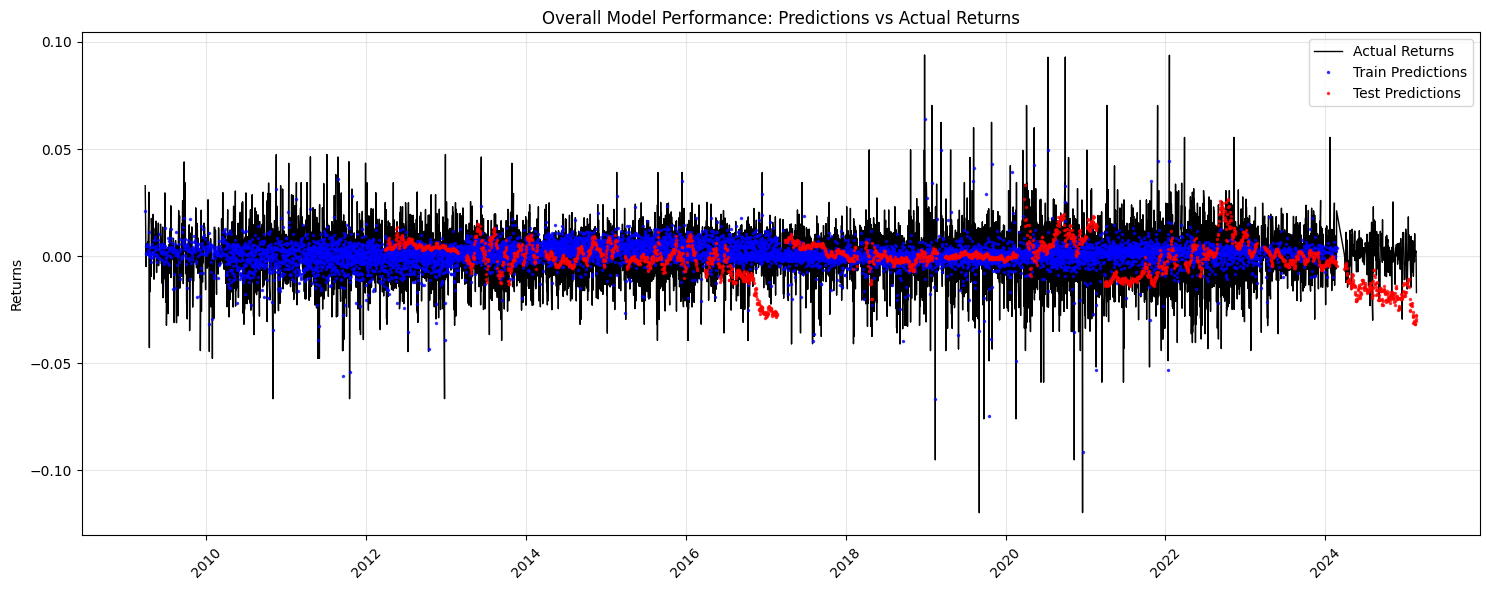

"model_kwargs={\n        'num_channels':[32, 64, 32], 'kernel_size':5, 'dropout':0.25\n    }"

In [141]:
class SimpleFeedForward(nn.Module):
    """Example feedforward model"""
    def __init__(self, input_dim, hidden_dim=200, dropout=0):
        super(SimpleFeedForward, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        return self.network(x)
    
class SimpleLSTM(nn.Module):
    """Example LSTM model"""
    def __init__(self, input_dim, hidden_dim=200, num_layers=2, dropout=0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(hidden_dim // 2, 1))
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Use last time step output

class SimpleTransformer(nn.Module):
    def __init__(self,
                 input_dim: int,
                 model_dim: int = 128,   # divisible by nhead
                 nhead: int = 8,
                 num_layers: int = 2,
                 dropout: float = 0.1,
                 max_seq_length: int = 500):  # for positional encoding
        super().__init__()

        # project raw features to model_dim
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Add positional encoding 
        self.pos_encoding = PositionalEncoding(model_dim, dropout, max_seq_length)

        # vanilla encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
                d_model=model_dim,
                nhead=nhead,
                dim_feedforward=model_dim * 4,  # standard practice
                dropout=dropout,
                activation='gelu',  # often works better than relu for transformers
                batch_first=True        # so x is (B, T, F)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # regression head with additional processing
        self.norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(model_dim, 1)

    def forward(self, x):               # x: (B, T, input_dim)
        x = self.input_proj(x)          # (B, T, model_dim)
        x = self.pos_encoding(x)        # Add positional information
        x = self.encoder(x)             # (B, T, model_dim)
        x = self.norm(x[:, -1])         # Layer norm on last time step
        x = self.dropout(x)             # Additional dropout
        return self.fc(x)               # (B, 1)

class SimpleConvolutional(nn.Module):
    """
    1-D CNN for sequence-to-one forecasting.
    Assumes input tensor shape: (batch, seq_len, n_features)
    """
    def __init__(
        self,
        input_dim: int,               # -- n_features after any AR-lag concat
        num_channels: List[int] = [32, 64, 32],
        kernel_size: int = 5,
        dropout: float = 0.25,
        seq_length: int = 12          # 〈NEW – keep default same as pipeline〉
    ):
        super(SimpleConvolutional, self).__init__()

        layers, in_channels = [], input_dim
        for out_channels in num_channels:
            layers += [
                nn.Conv1d(in_channels, out_channels,
                          kernel_size, padding=kernel_size // 2),
                nn.ReLU(),
                nn.MaxPool1d(2),
                nn.Dropout(dropout)
            ]
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        # ── force length-1 feature map so fc dim is invariant to seq_length ──
        self.pool = nn.AdaptiveAvgPool1d(1)                   # ← NEW
        self.fc   = nn.Linear(in_channels, 1)                 # 〈in_channels == last out_channels〉

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len, n_features)
        """
        x = x.transpose(1, 2)          # (batch, n_features, seq_len)
        x = self.conv(x)               # (batch, channels, L)
        x = self.pool(x)               # (batch, channels, 1)
        x = x.view(x.size(0), -1)      # (batch, channels)
        return self.fc(x).squeeze(-1)  # (batch,)
    
class PositionalEncoding(nn.Module):
    """Add positional encoding to input embeddings."""
    
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)
    
tbill3m_data = df["tbill3m"].values.astype(np.float32)

results_tcn = sp500_training_pipeline(
    X=features,
    y=target,
    dates=dates,
    tbill3m=tbill3m_data,
   model_class  = SimpleConvolutional,
    model_type   = 'cnn',                    # or 'simpleconvolutional'
    model_kwargs = {
        'num_channels': [32, 64, 32],
        'kernel_size' : 5,
        'dropout'     : 0.05
    },
    window_strategy='rolling',
    train_window_years=3,
    test_window_years=1,
    use_autoencoder=True,
    encoding_dim=10,
    seq_length=24,
    ar_lags=1,
    batch_size=32,
    epochs=80,
    lr=0.001,
    plot_results=True,
    alpha=0.0,
    l1_ratio=0.0,
)

"""model_kwargs={
        'num_channels':[32, 64, 32], 'kernel_size':5, 'dropout':0.25
    }"""
    

In [142]:
import importlib, sys
sym = importlib.import_module("sympy")
print("• Imported object :", sym)
print("• Version         :", getattr(sym, "__version__", " <no __version__>"))
print("• File            :", getattr(sym, "__file__", " <no __file__>"))
print("• printing attr?  :", hasattr(sym, "printing"))


• Imported object : <module 'sympy' from '/opt/anaconda3/envs/jupyterenv/lib/python3.10/site-packages/sympy/__init__.py'>
• Version         : 1.13.1
• File            : /opt/anaconda3/envs/jupyterenv/lib/python3.10/site-packages/sympy/__init__.py
• printing attr?  : True


In [143]:
results_tft = sp500_training_pipeline(
    X=features,
    y=target,
    dates=dates,
    tbill3m=tbill3m_data,
    model_class=TemporalFusionTransformer,
    model_kwargs={
        'hidden_dim': 128,
        'num_heads': 8,
        'num_layers': 2,
        'dropout': 0.1
    },
    model_type='tft',  # Use 'tft' as model_type
    window_strategy='rolling',
    train_window_years=3,
    test_window_years=1,
    use_autoencoder=True,
    encoding_dim=15,  # TFT can handle more complex features
    seq_length=18,
    ar_lags=5,
    epochs=80,
    lr=0.0005,  # Lower learning rate for TFT
    plot_results=True
)

NameError: name 'TemporalFusionTransformer' is not defined